### Now we continue talk about neural network and in this notebook we'll know how, using dataset we can do:
* Some augmentation.
* Early stopping
* Decaying learning rate

As always the implementation of new class you can see [here](https://github.com/analysiscenter/az_training/blob/anton_broilovskiy/task_03/MnistBatch.py).

In [1]:
import os
import sys

import blosc
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook as tqn
from matplotlib import pyplot as plt
%matplotlib inline
sys.path.append('..')

import utils
from MnistBatch import MnistBatch
from dataset import Dataset, DatasetIndex

As in previous times, we create dataset with our batch class and tenserflow session and train model after it.

In [2]:
ix = DatasetIndex(range(65000))
mnist = Dataset(ix, batch_class=MnistBatch)
mnist.cv_split([0.8, 0.1, 0.1])

In [3]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

It is worth paying attention to the fact that random_rotate and random_scale is elements of ImagesBatch class - it is parent our class. You can see all writing augmentations [here](https://github.com/analysiscenter/dataset/blob/master/examples/simple_but_ugly/image_basic.py).

In [4]:
train_loss = []
train_pipeline = (mnist.train
                  .p
                  .load(src='../MNIST_data', fmt='blosc')
                  .random_rotate(p=1, angle=(-45, 45), preserve_shape=True) #random rotate with angle 
                                                                              # from -30 degrees to 30 degrees
                  .random_scale(p=1, factor=(.7, 1.3)) # Resizing from 100% to random in (80% - 120%)
                  .train_conv(sess, train_loss))

In [5]:
stats = []
test_pipeline = (mnist.test
                 .p
                 .load(src='../MNIST_data', fmt='blosc')
                 .random_rotate(p=1, angle=(-45, 45), preserve_shape=True) # Random rotate with angle 
                                                                            # from -30 degrees to 30 degrees
                 .random_scale(p=1, factor=(.7, 1.3)) # Resizing from 100% to random in (80% - 120%)
                 .update_stats(sess, stats))

We introduce early stopping, if average accuracy for 'window' epochs will be more than 0.99.

In [6]:
MAX_ITER = 500
window = 50
average = [0]
batch_size = 100

for curr_iter in tqn(range(1, MAX_ITER + 1)):
    train_pipeline.next_batch(batch_size, n_epochs=None)
    test_pipeline.next_batch(batch_size, n_epochs=None)
    
    #Early stopping
    if curr_iter % window == 0:
        average.append(np.mean(stats[curr_iter - window:]))
        
    if average[-1] > 0.99:
        print('Early stop on {} iter. Acc: {}'.format(curr_iter, stats[-1]))
        break

Widget Javascript not detected.  It may not be installed or enabled properly.


Now we predict image class on validation data.

../utils.py:24: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(fitst), span=window, adjust=False)
../utils.py:25: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


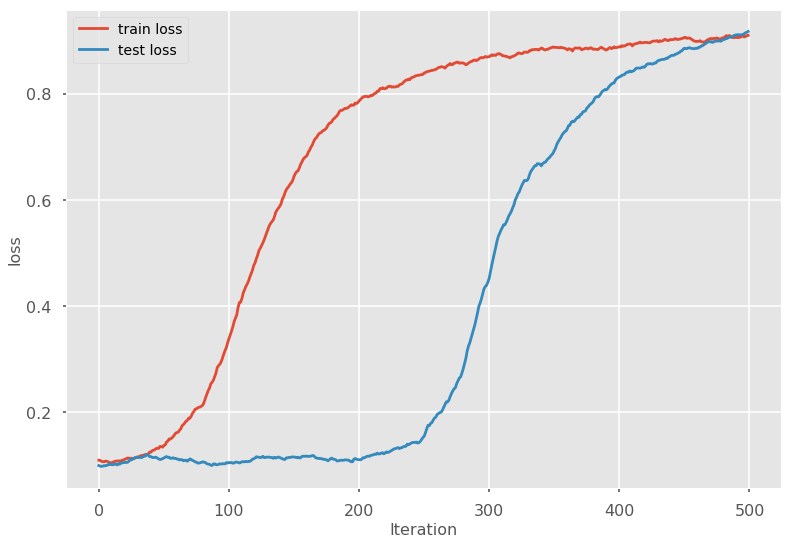

In [7]:
utils.draw(train_loss,'train', stats, 'test', 'loss')

In [8]:
dict_pred = {'imgs': [], 'predict': [], 'answer': []}
pred_pipeline = (mnist.validation
                .p
                .load(src='./../MNIST_data', fmt='blosc') 
                .random_rotate(p=1, angle=(-45, 45), preserve_shape=True)
                .random_scale(p=1, factor=(.7, 1.3))
                .prediction(sess, dict_pred))

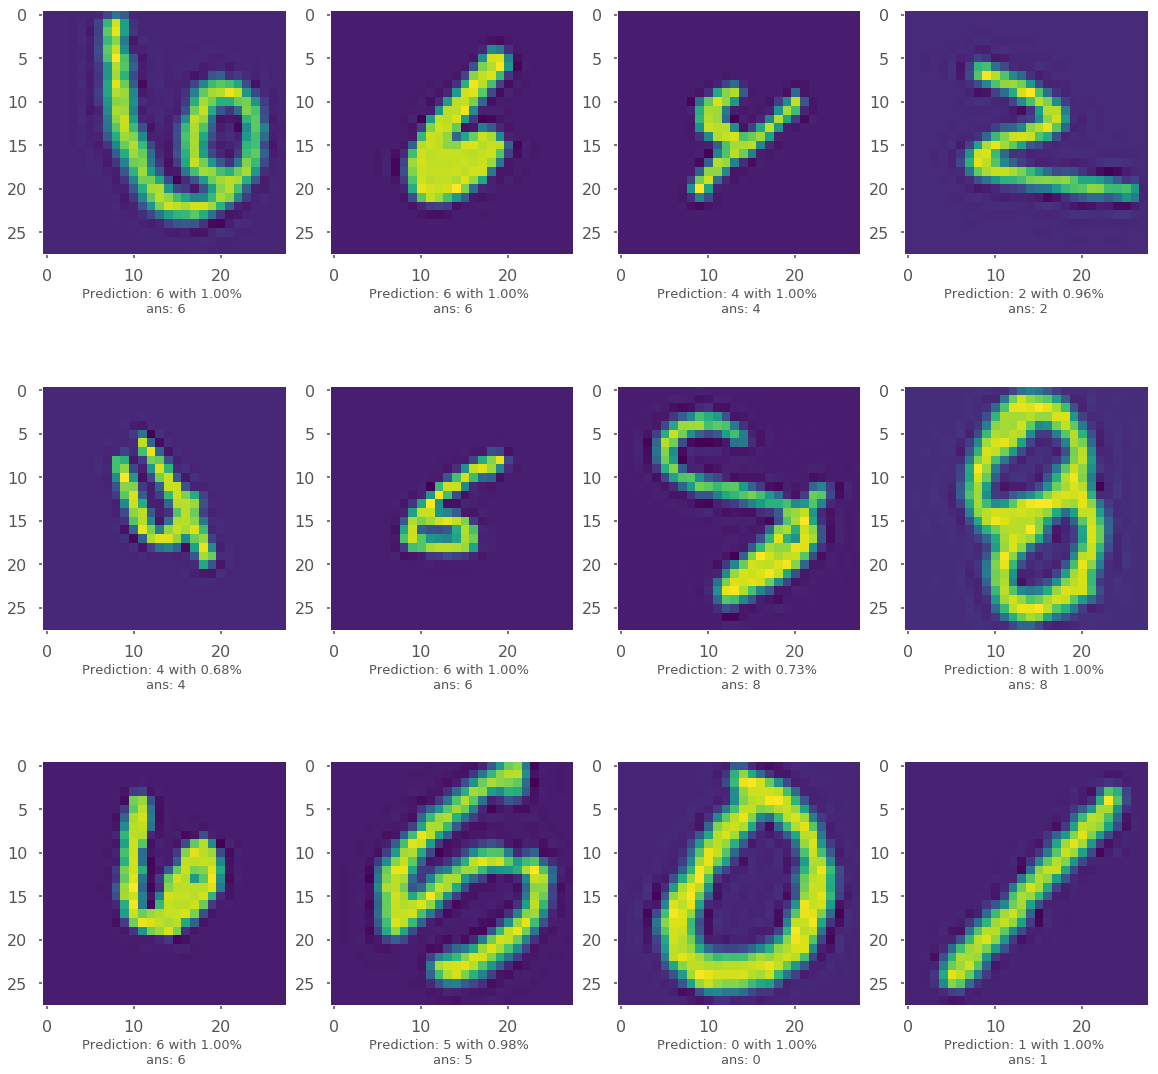

In [9]:
_, ax = plt.subplots(3, 4, figsize=(16, 16))
ax = ax.reshape(-1)

for num_batch in range(12):
    pred_pipeline.next_batch(1, n_epochs=None, shuffle=True)
    ax[num_batch].imshow(dict_pred['imgs'][-1].reshape(-1, 28))
    ax[num_batch].set_xlabel('Prediction: {} with {:.2f}% \n ans: {}'.format(np.argmax(dict_pred['predict'][-1][0]),
                                                            dict_pred['predict'][-1][0] \
                                                            [np.argmax(dict_pred['predict'][-1])], \
                                                            np.argmax(dict_pred['answer'][-1])), fontsize=13)
    ax[num_batch].grid()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

Not difficult to see, that network can teach rotate and scale changes.